In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from functools import lru_cache

## Data generation

In this experiment, ads do not have any marginal effect. In other words, the conversion probability is constant over time given by some $\alpha$. Additionally, we assume that if a user does not convert, they leave the system with probability $\beta$.

In [2]:
@lru_cache()
def generate_dataset_1(n_samples=10000, seed=320, alpha=0.1, beta=0.3):
  np.random.seed(seed)

  data_rows = []
  for i in range(n_samples):

    ads_seen = 0
    leave = 0
    time = 0
    total_conversion = 0

    while(leave==0):
        conversion = 0
        time += 1
        ads_seen += 1
        leave = int(np.random.rand() < beta)
        conversion = int(np.random.rand() < alpha)
        total_conversion += conversion

        data_rows += [
                    {"uid": i,
                     "time": time,
                     "features": [time],
                     "features_": str(time),
                     "conversion": 0}
                     ]
    if total_conversion > 0:
      data_rows[-1]['conversion'] = total_conversion

  ### Compute frequency of scenarios
  count_unique_scenario = np.unique(np.array(pd.DataFrame(data_rows).features_),return_counts=True)
  count_unique_scenario = dict(zip(count_unique_scenario[0],count_unique_scenario[1]))
  for i in range(len(data_rows)):
    scenario = data_rows[i]['features_']
    data_rows[i]['features_freq'] = count_unique_scenario.get(scenario)
  data = pd.DataFrame(data_rows)

  total_uid_rewards_df = data.groupby('uid').agg({'conversion': 'max'}).reset_index()
  total_uid_rewards_df.columns = ['uid', 'total_uid_rewards']
  data = data.merge(total_uid_rewards_df)

  return data

generate_dataset_1(n_samples=1000).head()

,uid,time,features,features_,conversion,features_freq,total_uid_rewards
0,0,1,[1],1,0,1000,1
1,0,2,[2],2,0,705,1
2,0,3,[3],3,0,483,1
3,0,4,[4],4,1,335,1
4,1,1,[1],1,0,1000,1


## Additivity metric
$$
\mathcal{L}^{\sf add}(V) = \dfrac{1}{T} \cdot \sum \limits_{u \in \mathcal{U}}  \left[ r_u \cdot \ln \left( \sum_{\boldsymbol{x} : u^t = u} V( \boldsymbol{x}) \right)  - \sum_{\boldsymbol{x} : u^t = u} V (\boldsymbol{x})\right].
$$

In [3]:
def additivity_metric(model_predictions, timeline_ids, uid_rewards):
  # Gather the attributions per timeline and obtain the sum of the predictions per timeline
  predictions_per_display = pd.DataFrame({
      'timeline_id': timeline_ids,
      'prediction': model_predictions,
      'uid_reward': uid_rewards,
  })

  sum_predictions_by_timeline = (
    predictions_per_display
    .groupby('timeline_id')
    .agg(sum_predictions=('prediction', 'sum'), uid_reward=('uid_reward', 'first'))
    .reset_index()
  )

  return (
    sum_predictions_by_timeline['uid_reward']
    * np.log(sum_predictions_by_timeline['sum_predictions'])
    - sum_predictions_by_timeline['sum_predictions']
  ).mean()

## Fixed point algorithm

We are implementing the following fixed-point algorithm

1. Generate training dataset by  attributing rewards at the display level with the label attribution $\mu^k$
   $$ \mathcal{S}^{(k)} \;\; = \;\; \big\{
       (\boldsymbol{x}^1, y^1) ,\dots, (\boldsymbol{x}^T,y^T)
       \big\}$$
  
2. Train any \textit{ML algorithm} on the training set $\mathcal{S}^{(k+1)}$. Update $\hat V^{(k+1)}$ to the resulting mapping. 

3. Update the label attribution $\mu^{(k+1)}$ with the fixed point characterization 
       $$\mu^{(k + 1)} \;\; = \;\; (\boldsymbol{x}^t | u^t) \mapsto  \frac{\hat V^{(k+1)}\big(\boldsymbol{x}^t\big)}{\sum_{\boldsymbol{x}' \in \mathcal{X}_{u^t}} \hat V^{(k+1)}  \big(\boldsymbol{x}'\big)} \cdot r_{u^t}.$$

In [4]:
def average_display_valuation_per_scenario_type(dataset, key="features_"):
  return (
    dataset.groupby(key)
      .agg(scenario_valuation=('labels', 'mean'))
      .reset_index()
  )


def compute_display_valuations_by_averaging(dataset):
  scenario_valuation = average_display_valuation_per_scenario_type(dataset, key="features_")
  return dataset.merge(scenario_valuation, on='features_', how='left')


def run_one_iteration(original_dataset, compute_display_valuations):
  current_dataset = original_dataset.copy()
  if "scenario_valuation" in current_dataset.columns:
    current_dataset.drop("scenario_valuation", inplace=True, axis=1)

  # Step 2, compute valuations
  current_dataset = compute_display_valuations(current_dataset)

  # Step 3, compute new labels proportionally to the display valuations
  total_uid_valuation = (
      current_dataset
      .groupby('uid')
      .agg(total_uid_valuation=('scenario_valuation', 'sum'))
      .reset_index()
  )

  merged_dataset = current_dataset.merge(total_uid_valuation, on='uid', how='left')
  current_dataset['labels'] = (
    merged_dataset['scenario_valuation']
    / merged_dataset['total_uid_valuation']
    * merged_dataset['total_uid_rewards']
  )

  return_columns = list(original_dataset.columns)
  if  "scenario_valuation" not in return_columns:
    return_columns += ["scenario_valuation"]
  return current_dataset[return_columns]


def compute_metrics(original_dataset, compute_display_valuations):
  current_dataset = original_dataset.copy()

  scenario_valuation = current_dataset.groupby("features_").agg({"scenario_valuation": "mean"}).reset_index()
  scenario_valuation_dict = {
    row['features_']: row['scenario_valuation']
    for _, row in scenario_valuation.iterrows()
  }

  if "scenario_valuation" in current_dataset.columns:
    current_dataset.drop("scenario_valuation", inplace=True, axis=1)

  dataset_with_valuations = current_dataset.merge(scenario_valuation, on='features_', how='left')

  current_additivity_metric = additivity_metric(
      dataset_with_valuations['scenario_valuation'],
      dataset_with_valuations['uid'],
      dataset_with_valuations['total_uid_rewards']
  )

  return scenario_valuation_dict, current_additivity_metric

In [7]:
def run_experiment(generate_dataset_fn, tol=1e-3):
  current_dataset = generate_dataset_fn()

  # Initialize with last click
  current_dataset['labels'] = current_dataset['conversion'].values

  scenario_valuations = []

  additivity_metrics = []
  last_likelihood = 0
  delta_likelihood = 1
  while delta_likelihood > tol:
    current_dataset = run_one_iteration(current_dataset, compute_display_valuations_by_averaging)
    scenario_valuation, current_additivity_metric = compute_metrics(current_dataset, compute_display_valuations_by_averaging)
    scenario_valuations += [scenario_valuation]
    additivity_metrics += [current_additivity_metric]
    delta_likelihood = np.abs(current_additivity_metric - last_likelihood)
    last_likelihood = current_additivity_metric

  return additivity_metrics, scenario_valuations

def print_valuations(time, scenario_valuations):
  print('Last touch')
  for t in time:
      print('(',t,',',scenario_valuations[0][t],')')

  print('FiPLA')
  for t in time:
      print('(',t,',',scenario_valuations[-1][t],')')

## Setup 1

In [9]:
N_SAMPLES = 3_000_000
TOL = 1e-5

In [10]:
additivity_metrics, scenario_valuations = run_experiment(lambda: generate_dataset_1(n_samples=N_SAMPLES, seed=2390, alpha=0.1, beta=0.3), tol=TOL)
scenario_valuations = [{k: scenario_valuation[str(k)] for k in sorted(map(int, scenario_valuation.keys()))} for scenario_valuation in scenario_valuations]

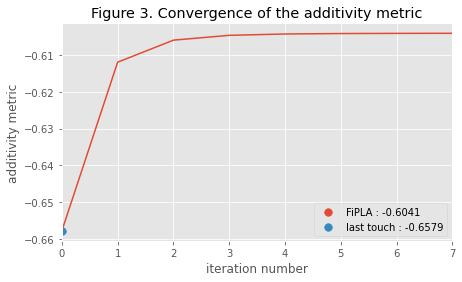

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax.set_title('Figure 3. Convergence of the additivity metric')
ax.plot(additivity_metrics)
ax.set_xlim([0, 7])
ax.set_ylabel('additivity metric')
ax.set_xlabel('iteration number')

llh_init = additivity_metrics[0]
llh_conv = additivity_metrics[-1]
ax.scatter(len(additivity_metrics) - 1, llh_conv, s=60, label=f'FiPLA : {llh_conv:.4f}', c='C0')
ax.scatter(0, llh_init, s=60, label=f'last touch : {llh_init:.4f}', c='C1')
ax.legend()
None

In [12]:
# for i in range(len(additivity_metrics)):
#    print('(',i,',',additivity_metrics[i],')')

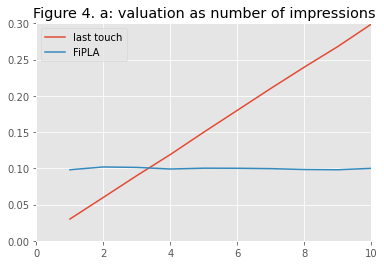

In [13]:
time = list(scenario_valuations[0].keys())
plt.plot(time, [scenario_valuations[0][t] for t in time], label='last touch')
plt.plot(time, [scenario_valuations[-1][t] for t in time],label='FiPLA')
plt.legend()
plt.xlim([0, 10])
plt.ylim([0, 0.3])
plt.title("Figure 4. a: valuation as number of impressions")
None

In [14]:
# print_valuations(time, scenario_valuations)

## Setup 2

In [15]:
@lru_cache()
def generate_dataset_2(n_samples=10000, seed=None, alpha = 0.1, beta =0.3):
  np.random.seed(seed)

  data_rows = []
  for i in range(n_samples):

    ads_seen = 0
    leave = 0
    time = 0
    total_conversion = 0

    while(leave==0):
        conversion = 0
        time += 1
        ads_seen += 1
        leave = int(np.random.rand() < beta)
        conversion = int(np.random.rand() < alpha)
        total_conversion += conversion

        data_rows += [
                    {"uid": i,
                     "time": time,
                     "features": [time],
                     "features_": str(time),
                     "conversion": 0}
                     ]

    total_conversion = np.minimum(total_conversion,1)
    if total_conversion > 0:
      data_rows[-1]['conversion'] = total_conversion



  ### Compute frequency of scenarios
  count_unique_scenario = np.unique(np.array(pd.DataFrame(data_rows).features_),return_counts=True)
  count_unique_scenario = dict(zip(count_unique_scenario[0],count_unique_scenario[1]))
  for i in range(len(data_rows)):
    scenario = data_rows[i]['features_']
    data_rows[i]['features_freq'] = count_unique_scenario.get(scenario)
  data = pd.DataFrame(data_rows)

  total_uid_rewards_df = data.groupby('uid').agg({'conversion': 'max'}).reset_index()
  total_uid_rewards_df.columns = ['uid', 'total_uid_rewards']
  data = data.merge(total_uid_rewards_df)

  return data

generate_dataset_2(n_samples=10000).head(5)

,uid,time,features,features_,conversion,features_freq,total_uid_rewards
0,0,1,[1],1,0,10000,0
1,0,2,[2],2,0,6962,0
2,0,3,[3],3,0,4822,0
3,1,1,[1],1,0,10000,0
4,2,1,[1],1,0,10000,1


In [16]:
additivity_metrics, scenario_valuations = run_experiment(lambda: generate_dataset_2(n_samples=N_SAMPLES,seed=2390, alpha=0.1, beta=0.3), TOL)
scenario_valuations = [{k: scenario_valuation[str(k)] for k in sorted(map(int, scenario_valuation.keys()))} for scenario_valuation in scenario_valuations]

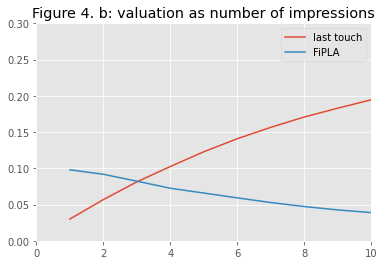

In [17]:
time = list(scenario_valuations[0].keys())
plt.plot(time, [scenario_valuations[0][t] for t in time],label='last touch')
plt.plot(time, [scenario_valuations[-1][t] for t in time],label='FiPLA')
plt.legend()
plt.xlim([0, 10])
plt.ylim([0, 0.3])
plt.title("Figure 4. b: valuation as number of impressions")
None

In [18]:
# print_valuations(scenario_valuations)

## Setup 3

In [19]:
@lru_cache()
def generate_dataset_3(n_samples=100000, seed=None, alpha_A = 0.2, alpha_B = 0.05, beta = 0.3):
  np.random.seed(seed)

  data_rows = []
  for i in range(n_samples):
    data_temp = []

    conversion = 0
    leave = 0
    time = 0
    number_display_A = 0
    number_display_B = 0
    total_conversion = 0

    while(leave==0):
      time += 1
      conversion = 0
      if np.random.rand() < 0.5:
        sampled_display = 1
      else:
        sampled_display = 0

      if sampled_display == 1:
        conversion = int(np.random.rand() < alpha_A)
      else:
        conversion = int(np.random.rand() < alpha_B)

      data_temp += [
                    {"uid": i,
                     "time": time,
                     "number_display_A": number_display_A,
                     "number_display_B": number_display_B,
                     "sampled_display": sampled_display,
                     "features": [number_display_A,number_display_B,sampled_display],
                     "features_": str(number_display_A)+'_'+str(number_display_B)+'_'+str(sampled_display),
                     "conversion": 0
                     }
                     ]

      if sampled_display == 1:
        number_display_A += 1
      else:
        number_display_B += 1


      total_conversion += conversion
      leave = int(np.random.rand() < beta)
    data_temp[-1]['conversion'] = total_conversion
    #total_conversion = np.minimum(total_conversion,1)

    data_rows += data_temp


  data = pd.DataFrame(data_rows)

  total_uid_rewards_df = data.groupby('uid').agg({'conversion': 'max'}).reset_index()
  total_uid_rewards_df.columns = ['uid', 'total_uid_rewards']
  data = data.merge(total_uid_rewards_df)

  return data

dataset = generate_dataset_3(n_samples=10_000)
dataset.head(5)

,uid,time,number_display_A,number_display_B,sampled_display,features,features_,conversion,total_uid_rewards
0,0,1,0,0,1,"[0, 0, 1]",0_0_1,0,0
1,1,1,0,0,0,"[0, 0, 0]",0_0_0,0,0
2,1,2,0,1,1,"[0, 1, 1]",0_1_1,0,0
3,1,3,1,1,0,"[1, 1, 0]",1_1_0,0,0
4,2,1,0,0,1,"[0, 0, 1]",0_0_1,0,0


In [20]:
additivity_metrics, scenario_valuations = run_experiment(lambda: generate_dataset_3(n_samples=N_SAMPLES, alpha_A=0.2, alpha_B = 0.05, beta = 0.3, seed=2390), TOL)

In [22]:
temp_mtc = pd.DataFrame(scenario_valuations[-1].items(), columns=['scenario', 'predicted_valuation'])
temp_lt = pd.DataFrame(scenario_valuations[0].items(), columns=['scenario', 'predicted_valuation'])

temp_mtc['number_display_A'] = temp_mtc['scenario'].apply(lambda x: x.split("_")[0]).astype(int)
temp_mtc['number_display_B'] = temp_mtc['scenario'].apply(lambda x: x.split("_")[1]).astype(int)
temp_mtc['sampled_display'] = temp_mtc['scenario'].apply(lambda x: x.split("_")[2]).astype(int)

temp_lt['number_display_A'] = temp_lt['scenario'].apply(lambda x: x.split("_")[0]).astype(int)
temp_lt['number_display_B'] = temp_lt['scenario'].apply(lambda x: x.split("_")[1]).astype(int)
temp_lt['sampled_display'] = temp_lt['scenario'].apply(lambda x: x.split("_")[2]).astype(int)

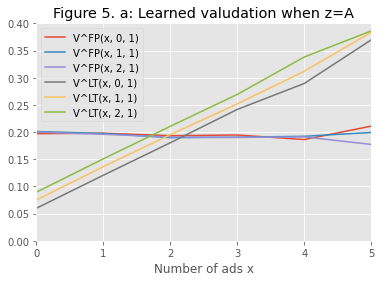

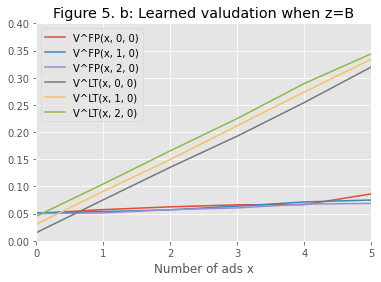

In [26]:
for sampled_display in [1, 0]:
  for data, data_label in zip([temp_mtc, temp_lt], ["FP", "LT"]):
    for number_display_B in [0, 1, 2]:
      label = f"V^{data_label}(x, {number_display_B}, {sampled_display})"
      serie = data[(data["number_display_B"] == number_display_B) & (data["sampled_display"] == sampled_display)].sort_values("number_display_A")["predicted_valuation"].values
      plt.plot(serie, label=label)
      #print()
      #print(label)
      #for i in range(min(11, len(serie))):
      #  print(f'({i}, {serie[i]})')

  if sampled_display == 0:
    plt.title("Figure 5. b: Learned valudation when z=B")
  else:
    plt.title("Figure 5. a: Learned valudation when z=A")
  
  plt.legend()
  plt.xlim(0, 5)
  plt.ylim(0, 0.4)
  plt.xlabel("Number of ads x")
  plt.show()